Create matrix.csv from matrix.mtx file

In [16]:
from scipy.io import mmread
from scipy.sparse import save_npz
import numpy as np

path = 'data/sample1/GSE294399_WBC_020823_matrix.mtx/matrix.mtx'
sparse_matrix = mmread(path)
csr = sparse_matrix.tocsr()
#save_npz("data/sample1/csc.npz", csc_matrix)
np.savez("data/sample1/matrix.csr", data=csr.data, indices=csr.indices, indptr=csr.indptr, shape=csr.shape)

Clustering algorithm using a neural network

2025-05-07 23:08:28.875952: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 23:08:29.221884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 23:08:30.256540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-05-07 23:09:05.697003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-07 23:09:05.895

Epoch 1/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0308
Epoch 2/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0051
Epoch 3/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0050
Epoch 4/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0049
Epoch 5/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 6/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0046
Epoch 7/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 8/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0044
Epoch 9/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 10/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0044
Epoch 11/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 12/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0043
E

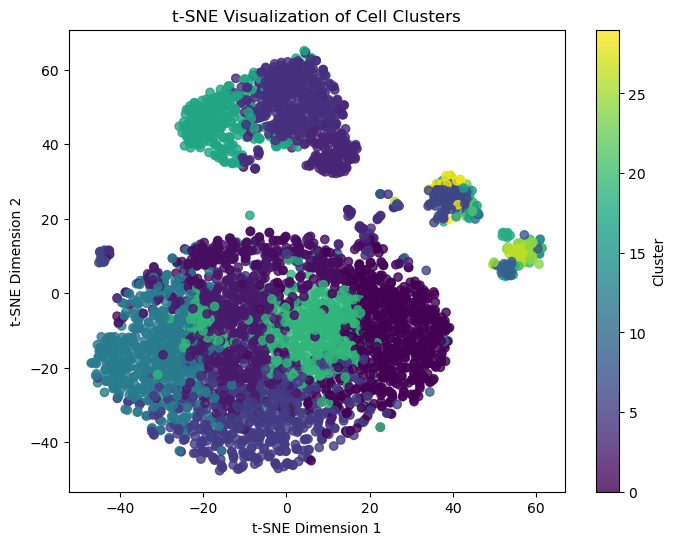

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE  # For 2D visualization
from keras.layers import Input, Dense, Layer
from keras.models import Model
from keras import backend as K

# Load data
data = pd.read_csv('matrix.csv', index_col=0)
X = data.values

# Preprocessing
X = np.log1p(X)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1]
encoding_dim = 32  # Latent space dimension
n_clusters = 30     # Adjust based on your data

# Step 1: Pretrain Autoencoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, shuffle=True)

# Extract encoded features
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_data = encoder_model.predict(X_scaled)

# Step 2: Initialize Clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(encoded_data)
cluster_centers = kmeans.cluster_centers_

# Step 3: Define Clustering Layer (same as before)
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights

    def build(self, input_shape):
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_shape[1]),
            initializer='glorot_uniform',
            name='clusters'
        )
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

# Build and train clustering model (same as before)
clustering_layer = ClusteringLayer(n_clusters, weights=[cluster_centers], name='clustering')(encoder)
clustering_model = Model(inputs=input_layer, outputs=clustering_layer)
clustering_model.compile(optimizer='adam', loss='kld')

# Step 4: Define Target Distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(axis=0)
    return (weight.T / weight.sum(axis=1)).T

# Train with target distribution
max_iter = 20
for epoch in range(max_iter):
    q = clustering_model.predict(X_scaled, verbose=0)
    p = target_distribution(q)
    clustering_model.fit(X_scaled, p, epochs=1, batch_size=32, verbose=0)

# Get final cluster labels
q_final = clustering_model.predict(X_scaled, verbose=0)
cluster_labels = np.argmax(q_final, axis=1)

# Step 4: Plot Clusters in 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(encoded_data)  # Use encoded features

plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.8
)
plt.title('t-SNE Visualization of Cell Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

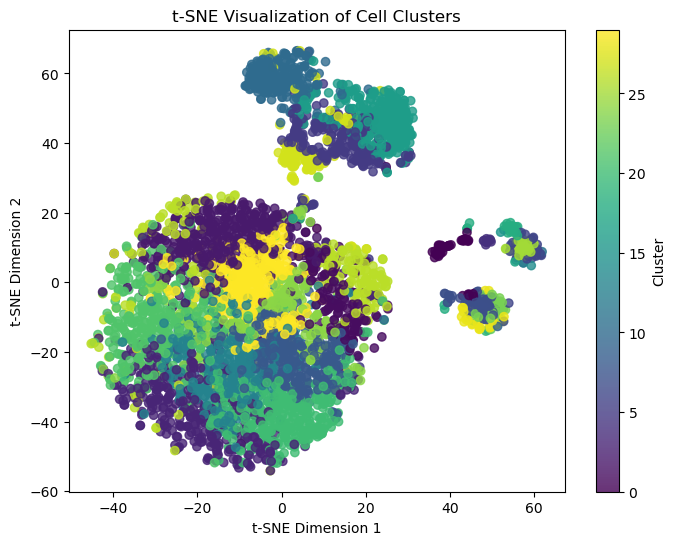

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.8
)
plt.title('t-SNE Visualization of Cell Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
#plt.savefig('/home/neko/spring2025/scRNA_Compression/compressed/neural/clusters.png')
plt.show()

Save cluster assignments

In [2]:
import pickle

# Pickle the array and save to a file
filename = 'compressed/neural/cluster_labels.pkl'
with open(filename, 'wb') as file:
    pickle.dump(cluster_labels, file)

Load cluster assignments

In [2]:
import pickle

filename = 'compressed/neural/cluster_labels.pkl'
with open(filename, 'rb') as file:
    # Load the pickled object from the file
    cluster_labels = pickle.load(file)